<a href="https://colab.research.google.com/github/renatovicente/Modelos-Gerativos-Teoria-e-Pratica/blob/main/notebooks/A1/AssimetriaKL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

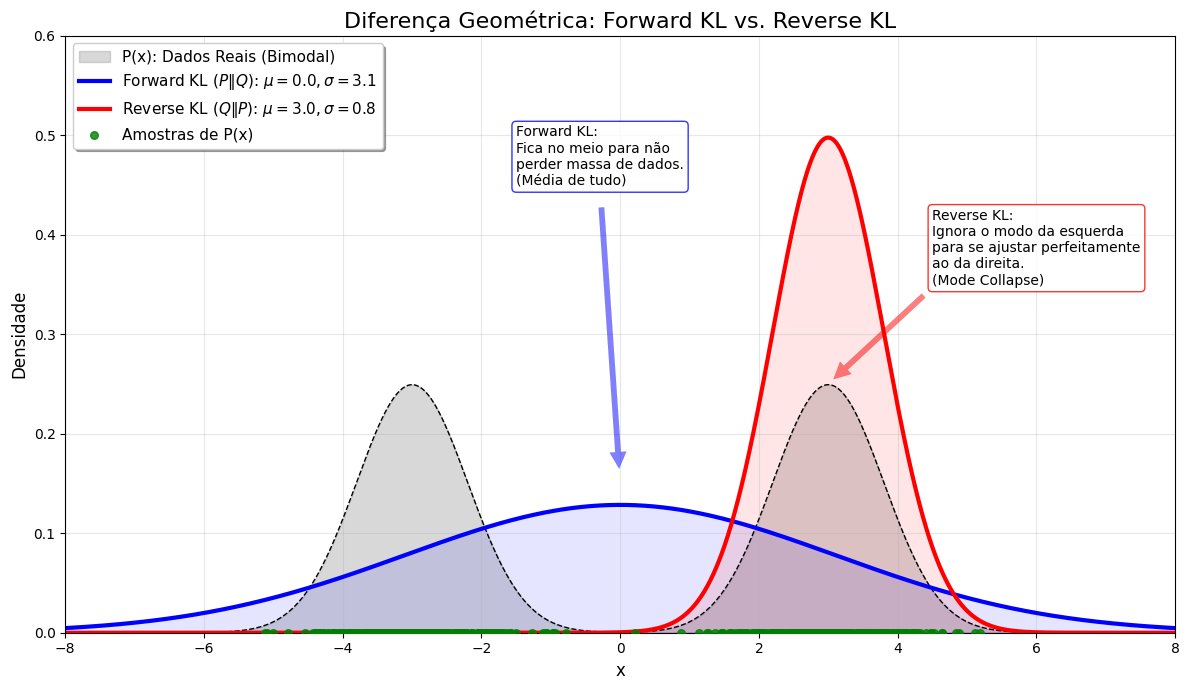

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

# 1. Configuração do Espaço
np.random.seed(42)
x_grid = np.linspace(-8, 8, 2000)
dx = x_grid[1] - x_grid[0]

# 2. Distribuição Alvo P(x) - Bimodal (Mistura de Gaussianas)
def p_pdf(x):
    # Modo 1 em -3, Modo 2 em +3
    return 0.5 * norm.pdf(x, loc=-3, scale=0.8) + \
           0.5 * norm.pdf(x, loc=3, scale=0.8)

P = p_pdf(x_grid)

# 3. Distribuição do Modelo Q(x) - Unimodal
def q_pdf(x, mu, sigma):
    # Proteção contra sigma <= 0
    if sigma <= 1e-6: sigma = 1e-6
    return norm.pdf(x, loc=mu, scale=sigma)

# 4. Funções de Custo (Com proteção numérica)
EPS = 1e-12

def forward_kl_loss(params):
    # J = Integral P(x) * log(P(x)/Q(x)) dx
    # Equivalente a minimizar: - Integral P(x) * log(Q(x)) dx
    mu, sigma = params
    Q = q_pdf(x_grid, mu, sigma)
    Q = np.maximum(Q, EPS) # Evitar log(0)

    # Cross Entropy term (only part that depends on theta)
    loss = -np.sum(P * np.log(Q)) * dx
    return loss

def reverse_kl_loss(params):
    # J = Integral Q(x) * log(Q(x)/P(x)) dx
    # Minimiza: Integral Q * log(Q) - Integral Q * log(P)
    mu, sigma = params
    Q = q_pdf(x_grid, mu, sigma)
    P_safe = np.maximum(P, EPS)
    Q_safe = np.maximum(Q, EPS)

    term1 = Q_safe * np.log(Q_safe)
    term2 = Q_safe * np.log(P_safe)
    loss = np.sum(term1 - term2) * dx
    return loss

# 5. Otimização com Limites (Bounds)
# Limites para mu (-8 a 8) e sigma (0.1 a 10)
bounds = [(-8, 8), (0.1, 10)]

# --- Otimização Forward KL ---
# Chute inicial no centro (0). Deve alargar para cobrir tudo.
res_fwd = minimize(forward_kl_loss, x0=[0.0, 1.0], bounds=bounds, method='L-BFGS-B')
mu_fwd, sigma_fwd = res_fwd.x
Q_fwd = q_pdf(x_grid, mu_fwd, sigma_fwd)

# --- Otimização Reverse KL ---
# Chute inicial levemente à direita (2.0). Deve "sugar" para o modo em 3.0.
# Se começasse em 0, poderia ficar preso num ótimo local instável.
res_rev = minimize(reverse_kl_loss, x0=[2.0, 1.0], bounds=bounds, method='L-BFGS-B')
mu_rev, sigma_rev = res_rev.x
Q_rev = q_pdf(x_grid, mu_rev, sigma_rev)

# 6. Plotagem Visual
plt.figure(figsize=(12, 7))

# P(x) - A Realidade
plt.fill_between(x_grid, P, color='gray', alpha=0.3, label='P(x): Dados Reais (Bimodal)')
plt.plot(x_grid, P, 'k--', linewidth=1)

# Forward KL - O Borrão (Zero Avoiding)
plt.plot(x_grid, Q_fwd, color='blue', linewidth=3, linestyle='-',
         label=fr'Forward KL ($P\|Q$): $\mu={mu_fwd:.1f}, \sigma={sigma_fwd:.1f}$')
plt.fill_between(x_grid, Q_fwd, color='blue', alpha=0.1)

# Reverse KL - O Especialista (Zero Forcing)
plt.plot(x_grid, Q_rev, color='red', linewidth=3, linestyle='-',
         label=fr'Reverse KL ($Q\|P$): $\mu={mu_rev:.1f}, \sigma={sigma_rev:.1f}$')
plt.fill_between(x_grid, Q_rev, color='red', alpha=0.1)

# Adicionar amostras de P(x) ao gráfico
num_samples = 500
samples = np.zeros(num_samples)
for i in range(num_samples):
    if np.random.rand() < 0.5:
        samples[i] = norm.rvs(loc=-3, scale=0.8)
    else:
        samples[i] = norm.rvs(loc=3, scale=0.8)

plt.scatter(samples, np.zeros_like(samples), color='green', alpha=0.8, label='Amostras de P(x)', s=30, zorder=5) # zorder para garantir que as amostras fiquem visíveis

# Anotações Didáticas
plt.annotate('Forward KL:\nFica no meio para não\nperder massa de dados.\n(Média de tudo)',
             xy=(0, 0.15), xytext=(-1.5, 0.45),
             arrowprops=dict(facecolor='blue', shrink=0.05, alpha=0.5, linewidth=0.1),
             bbox=dict(boxstyle="round", fc="w", ec="b", alpha=0.8))

plt.annotate('Reverse KL:\nIgnora o modo da esquerda\npara se ajustar perfeitamente\nao da direita.\n(Mode Collapse)',
             xy=(3, 0.25), xytext=(4.5, 0.35),
             arrowprops=dict(facecolor='red', shrink=0.05, alpha=0.5, linewidth=0.1),
             bbox=dict(boxstyle="round", fc="w", ec="r", alpha=0.8))

plt.title('Diferença Geométrica: Forward KL vs. Reverse KL', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend(loc='upper left', fontsize=11, framealpha=1, shadow=True)
plt.grid(True, alpha=0.3)
plt.xlim(-8, 8)
plt.ylim(0, 0.6)

plt.tight_layout()
plt.show()